In [18]:
# IMPORT LIBRARIES AND NOISE DATA FILE
import csv, glob, os, sys, numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import timeit
from scipy.optimize import curve_fit
from scipy import optimize
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy import signal
from numpy import NaN, Inf, arange, isscalar, asarray, array
import numpy.polynomial.polynomial as poly
from theano.tensor.signal.pool import pool_2d
from sknn.mlp import Regressor, Layer
from sklearn.preprocessing import StandardScaler 
from scipy import stats; from sklearn import preprocessing
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import train_test_split
from timeit import default_timer as timer
from sklearn.model_selection import KFold

def MSE(y,y0): #create mean-square error function to calculate ANN performance
    if len(y.shape) > 1:
        y = np.squeeze(y)
    if len(y0.shape) > 1:
        y0 = np.squeeze(y0)
    return (np.average((y - y0)**2))/np.average(y)*100


plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15 #make size of axis tick labels larger

#################################################################
noisefile = 'C:\\Users\\a6q\\Desktop\\CorrEL noise measurements\\2017-08-02 s-swcnt noise offset.txt' #CorrEl NOISE filename
sdline1, sdline2 = 14, 99 #lines to start and stop import of standard deviation data
#################################################################
sddata = pd.read_table(noisefile, skiprows=sdline1, error_bad_lines=False, sep='\s+') #read in file
sddata = sddata[:sdline2].apply(pd.to_numeric, errors='coerce') #str to flt, coerce to NaN, and erase past st. dev. data
print(sddata)

b'Skipping line 5217: expected 6 fields, saw 7\n'
C:\Users\a6q\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


          time             /             s  volt.noise/V  curr.noise/A  \
0       0.0000  1.060000e-05  1.660000e-09  3.510000e-15           NaN   
1    1000.0000  1.070000e-05  1.660000e-09  3.700000e-15           NaN   
2    2000.0000  1.060000e-05  1.650000e-09  3.410000e-15           NaN   
3    3000.0000  1.030000e-05  1.560000e-09  3.090000e-15           NaN   
4    4000.0000  1.010000e-05  1.540000e-09  2.770000e-15           NaN   
5    5000.0000  1.030000e-05  1.610000e-09  2.980000e-15           NaN   
6    6000.0000  1.020000e-05  1.510000e-09  2.700000e-15           NaN   
7    7000.0000  1.030000e-05  1.680000e-09  3.240000e-15           NaN   
8    8000.0000  1.020000e-05  1.610000e-09  3.100000e-15           NaN   
9    9000.0000  1.020000e-05  1.680000e-09  3.060000e-15           NaN   
10  10000.0000  1.000000e-05  1.660000e-09  2.810000e-15           NaN   
11  11000.0000  1.000000e-05  1.640000e-09  3.010000e-15           NaN   
12  12000.0000  1.010000e-05  1.700000

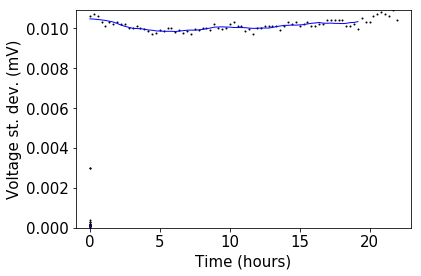

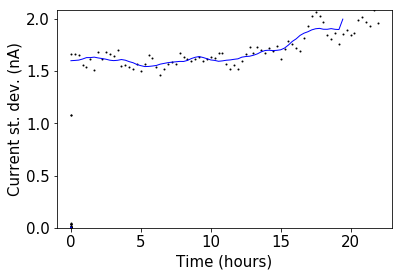

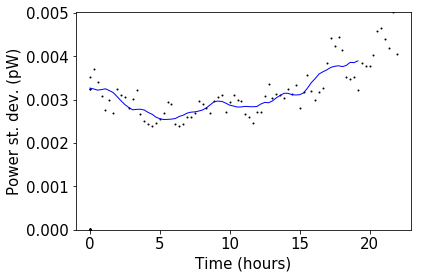

In [19]:
# ORGANIZE AND PLOT STANDARD DEVIATION VS. TIME DATA FROM NOISE FILE
sdtime = np.array(sddata['time'])/3600
sdv = np.array(sddata['/'])*1e3 #voltage in mVolts
sdi = np.array(sddata['s'])*1e9 #current in nanoAmps
sdp = np.array(sddata['volt.noise/V'])*1e12 #power in pWatts

sdvars = [sdv, sdi, sdp] #list for sd plotting
sdlabels = ['Voltage st. dev. (mV)', 'Current st. dev. (nA)', 'Power st. dev. (pW)'] #list for y labels of plots
for i in range(len(sdvars)):
    #filter data for smoothing
    sdfilt = savgol_filter(sdvars[i], 21, 2, mode='mirror') #points, polynomial order, bound. cond.
    plt.plot(sdtime, sdfilt, color='b', linewidth=1) #plot filtered data
    plt.scatter(sdtime, sdvars[i], s=1, color='k') #plot raw sd data
    plt.xlabel('Time (hours)', fontsize=15); plt.ylabel(sdlabels[i], fontsize=15)
    plt.axis((min(sdtime)-1, max(sdtime)+1, min(sdvars[i]), max(sdvars[i])))
    plt.show()

In [20]:
# EXTRACT FREQUENCY DATA FROM NOISE FILE #############################################################
fline1 = sdline2 -2 #lines to start and stop import of frequency data

#####################################################################################################
fdata0 = pd.read_table(noisefile, skiprows=fline1, header=0, error_bad_lines=False, sep='\s+') #read in file
fdata = fdata0.apply(pd.to_numeric, errors='coerce').dropna() #change from string to float, coercing to NaN 
print(fdata)

b'Skipping line 5217: expected 4 fields, saw 7\n'
C:\Users\a6q\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


      Frequency/Hz  volt.noise/V  curr.noise/A   pow.noise/W
0           0.0000  3.000000e-06  1.080000e-09  3.250000e-15
1           0.0005  3.000000e-06  1.080000e-09  3.250000e-15
2           0.0010  2.060000e-07  3.440000e-11  7.080000e-18
3           0.0015  3.160000e-07  3.740000e-11  1.180000e-17
4           0.0020  4.190000e-07  3.520000e-11  1.480000e-17
5           0.0025  3.100000e-07  4.050000e-11  1.260000e-17
6           0.0030  2.130000e-07  4.560000e-11  9.720000e-18
7           0.0035  1.300000e-07  1.930000e-11  2.520000e-18
8           0.0040  1.680000e-07  6.700000e-12  1.130000e-18
9           0.0045  9.980000e-09  3.850000e-13  3.840000e-21
10          0.0050  1.510000e-07  4.280000e-12  6.440000e-19
11          0.0055  8.930000e-08  3.640000e-12  3.250000e-19
12          0.0060  9.160000e-08  3.960000e-12  3.620000e-19
13          0.0065  8.510000e-08  4.870000e-12  4.140000e-19
14          0.0070  1.560000e-07  8.630000e-12  1.350000e-18
15          0.0075  3.65

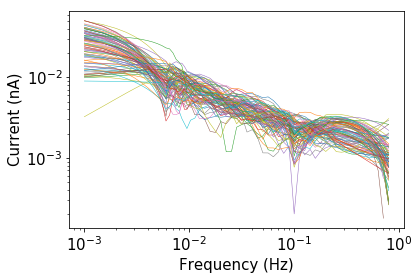

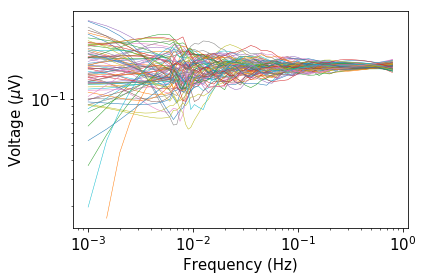

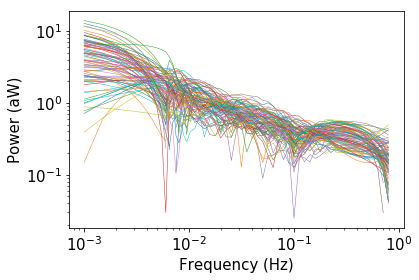

In [21]:
# PLOT FREQUENCY DOMAIN DATA
allf = np.array(fdata['Frequency/Hz']) #frequency in Hz
allv = np.array(fdata['volt.noise/V'])*1e6 #voltage in microVolts
alli = np.array(fdata['curr.noise/A'])*1e9 #current in nanoAmps
allp = np.array(fdata['pow.noise/W'])*1e18 #power in attoWatts

fsweep = []; i=0
while allf[i+1] > allf[i]: fsweep.append(allf[i]); i=i+1 #find length of each freq sweep

fmat0 = np.reshape(allf, (-1,len(fsweep)+1)); imat0 = np.reshape(alli, (-1,len(fsweep)+1)) #reshape into matrices
vmat0 = np.reshape(allv, (-1,len(fsweep)+1)); pmat0 = np.reshape(allp, (-1,len(fsweep)+1))

#set starting/ending indices to remove errant points from freq. measurements############################
si, ei = 2, 2
########################################################################################################
#new empty matrices without first/last couple points
fmat = np.ones((np.shape(fmat0)[0],np.shape(fmat0)[1]-si-ei));
vmat=np.copy(fmat); imat=np.copy(fmat); pmat=np.copy(fmat); zmat=np.copy(fmat)

for i in range(len(fmat)): #create matrices without the first/last couple points
    fmat[i] = fmat0[i][si:-ei]; vmat[i] = vmat0[i][si:-ei]
    imat[i] = imat0[i][si:-ei]; pmat[i] = pmat0[i][si:-ei]
    
fvars = [imat, vmat, pmat] #make lists for looping over plots
flabels = ['Current (nA)', 'Voltage ($\mu$V)', 'Power (aW)']

for j in range(len(flabels)): #plot filtered freq-dependent noise spectra
    for i in range(len(fmat)): 
        ffilt = savgol_filter(fvars[j][i], 21, 2, mode='interp') #points, polynomial order, bound. cond.
        plt.loglog(fmat[i],ffilt, linewidth=.5) #plot noise
    plt.xlabel('Frequency (Hz)',fontsize=15); plt.ylabel(flabels[j],fontsize=15)
    plt.show()

# FIT FREQUENCY DOMAIN DATA fit noise to pink (1/f) or brown (1/f^2)
timecycle = np.arange(len(fmat))*1000/60/60 #create time array

def noisefit(f, c, n):  # define variables in each function
    return c / f**n

for k in range(len(fvars)): #loop over varibles (current, power, impedance)
    clist = []; nlist = [] #save lists of fitting parameters
    for i in range(len(fmat)): #loop over number of timing cycles
        try:
            popt, pcov = curve_fit(noisefit, fmat[i], ffilt)# fvars[k][i]) #find fit parameters
            fit =  noisefit(fmat[i], *popt) #build fit line
            c = popt[0]; n = popt[1] #get fitting parameters from popt
            clist.append(c); nlist.append(n)
        
            plt.semilogy(fmat[i],fvars[k][i]) #plot fits
            plt.plot(fmat[i],fit,linewidth=1, c='k')
        
        except RuntimeError: #if error in fitting, keep going amnd assign 0 values
            clist.append(0); nlist.append(0)
            print('error in fitting column index ' + format(i))

    plt.xlabel('Frequency (Hz)',fontsize=15); plt.ylabel(flabels[k],fontsize=15);
    plt.show()

    plt.plot(timecycle,clist)
    plt.xlabel('Time',fontsize=15); plt.ylabel('c : ' + flabels[k],fontsize=15); plt.show()

    plt.plot(timecycle,nlist)
    plt.xlabel('Time',fontsize=15); plt.ylabel('n : ' + flabels[k],fontsize=15); plt.show()


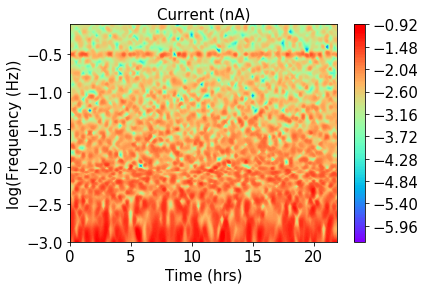

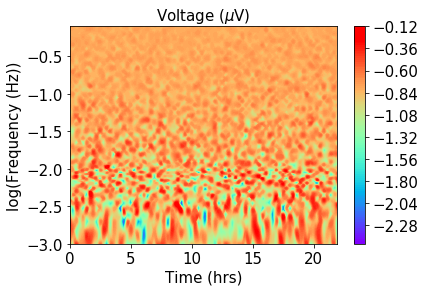

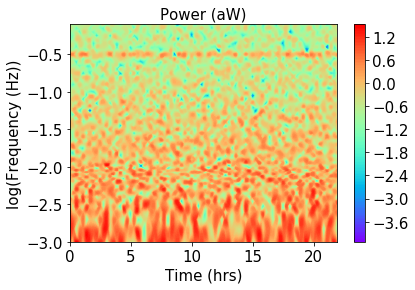

In [22]:
# PLOT IN FREQUENCY DOMAIN OVER TIME
tmatflat = np.array([]) #make flat array of repeating "times"
for i in range(len(fmat)): tmatflat = np.append(tmatflat, np.ones(len(fmat[0]))*i*1000/60/60)

fmatflat = fmat.flatten(); imatflat = imat.flatten()
vmatflat = vmat.flatten(); pmatflat = pmat.flatten()

Zlist = [imatflat, vmatflat, pmatflat] #list of Z values in heatmaps
heatmaplabels = ['Current (nA)', 'Voltage ($\mu$V)', 'Power (aW)']


for i in range(len(Zlist)):  # plot heatmaps of time/frequency-dependent noise
    # set X, Y, and Z for plot
    X, Y, Z, = tmatflat, np.log10(fmatflat), np.log10(Zlist[i]) #time, frequency, noise

    # create x-y points to be used in heatmap
    xi = np.linspace(X.min(),X.max(),1000)
    yi = np.linspace(Y.min(),Y.max(),1000)
    # Z is a matrix of x-y values
    zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

    # Create the contour plot
    CS = plt.contourf(xi, yi, zi, 150, cmap=plt.cm.rainbow, vmax=np.nanmax(Z), vmin=np.nanmin(Z))
    plt.colorbar(); plt.xlabel('Time (hrs)',fontsize=15); plt.ylabel('log(Frequency (Hz))',fontsize=15);
    plt.title(heatmaplabels[i],fontsize=15); plt.show()

In [23]:
# EXTRACT TIME-DOMAIN DATA ##########################################################################################
tskip = 5217
tdata = pd.read_csv(noisefile, skiprows=tskip, header=0, error_bad_lines=False, sep='\s+') #read in file
####################################################################################################################
tfloatdata = tdata.apply(pd.to_numeric, errors='coerce') #change from string to float, coercing to NaN 
print(tfloatdata)

        volt.noise/V  curr.noise/A
0      -2.840740e-10  1.345720e-09
1      -1.525860e-05  9.856370e-10
2      -1.525860e-05  1.594490e-09
3      -2.840740e-10  9.444720e-10
4      -1.525860e-05  1.521230e-09
5      -2.840740e-10  1.298510e-09
6      -1.525860e-05  2.395260e-10
7      -1.525860e-05  1.530400e-09
8      -1.525860e-05  1.438900e-09
9      -1.525860e-05  2.841180e-09
10     -2.840740e-10  6.255570e-10
11     -1.525860e-05  1.710490e-09
12     -2.840740e-10  1.556310e-10
13     -1.525860e-05  1.785220e-09
14     -2.840740e-10  8.544240e-10
15     -1.525860e-05  2.116320e-09
16     -1.525860e-05  9.841820e-10
17     -2.840740e-10  7.430110e-10
18     -1.525860e-05  1.946970e-09
19     -2.840740e-10  3.569800e-10
20     -2.840740e-10  1.921020e-09
21     -2.840740e-10  2.532850e-10
22     -2.840740e-10  2.420030e-09
23     -1.525860e-05  9.474920e-10
24     -1.525860e-05  1.852330e-09
25     -2.840740e-10  6.026260e-10
26     -1.525860e-05  1.347280e-09
27     -2.840740e-10

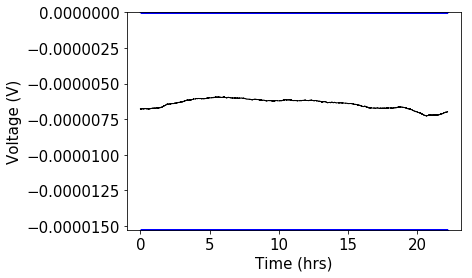

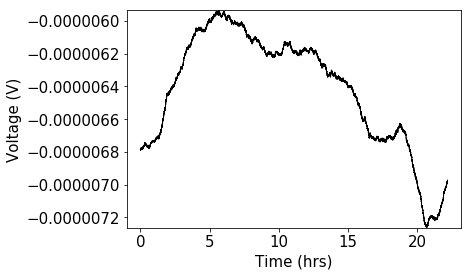

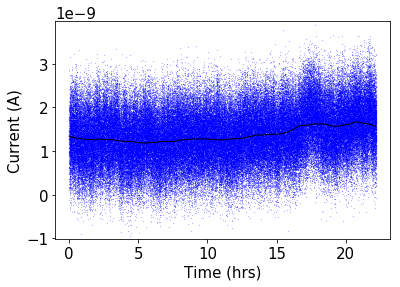

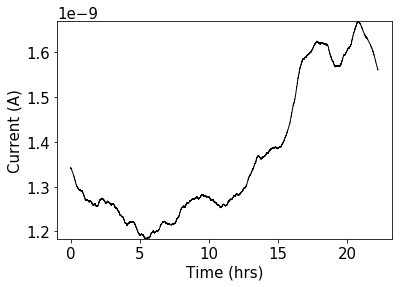

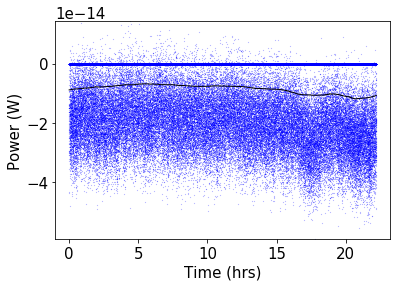

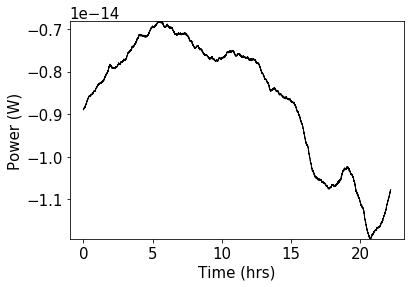

In [24]:
#ORGANIZE AND FILTER/SMOOTH TIME-DOMAIN DATA
from scipy import signal

vt = np.array(tfloatdata['volt.noise/V']) #create voltage nad current arrays for time-domain data 
it = np.array(tfloatdata['curr.noise/A'])
pt = np.multiply(vt,it) #calculate power noise

tlong = (np.arange(len(vt))*0.488)/60/60 #create time array in hours

############### Filter signals to smooth them ####################################
filtwindow = 20001 # number of points to use for filtering
filtorder = 1 #polynomial order ot use for filtering
filtmode = 'constant' #'mirror', 'constant', 'wrap', 'nearest' #mode for dealing with boundary conditions

cval = []; cval_filling = [vt, it, pt]; padpoints = 1000 # number of points to use for pad average
for i in range(len(cval_filling)): #average first and last 100 point values to be constants for padding filter 
    cval.append(np.mean((cval_filling[i][si:si+padpoints]) +
                        np.mean(cval_filling[i][-ei-padpoints:-ei]))/2)

vtfilt = savgol_filter(vt, filtwindow, filtorder, mode=filtmode, cval=cval[0])
itfilt = savgol_filter(it, filtwindow, filtorder, mode=filtmode, cval=cval[1])
ptfilt = savgol_filter(pt, filtwindow, filtorder, mode=filtmode, cval=cval[2])
##################################################################################
tvars = [vt, it, pt, np.divide(vt,it)] #create lists for looping
tfiltvars = [vtfilt, itfilt, ptfilt]
tlabels = ['Voltage (V)', 'Current (A)', 'Power (W)']

for i in range(len(tfiltvars)): #plot noise with smoothed curves
    plt.plot(tlong, tfiltvars[i],linewidth=1, c='k') #plot filtered/smoothed data
    plt.scatter(tlong, tvars[i], s=.01, c='b') #plot raw data
    plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel(tlabels[i], fontsize=15)
    plt.axis((min(tlong)-1,max(tlong)+1,min(tvars[i]), max(tvars[i])))
    plt.show()
    
    plt.plot(tlong, tfiltvars[i],linewidth=1, c='k') #plot ONLY filtered/smoothed data
    plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel(tlabels[i], fontsize=15)
    plt.axis((min(tlong)-1,max(tlong)+1,min(tfiltvars[i]), max(tfiltvars[i])))
    plt.show()

In [16]:
# IMPORT PRESSURE DATA
pressurefile = 'C:\\Users\\a6q\\Desktop\\CorrEL noise measurements\\2017-08-02 s-swcnt h2o'
pressuredata = pd.read_csv(pressurefile, delimiter = '\t')# skiprows=fline1, header=0, error_bad_lines=False, sep='\s+') #read in file
#fdata = fdata0.apply(pd.to_numeric, errors='coerce').dropna() #change from string to float, coercing to NaN 
print(pressuredata)

                   date_time  elapsed_time_min  J-KEM_temp_C  \
0     2017-08-01 17:07:06.81        270.349680          26.8   
1     2017-08-01 17:07:24.01        270.636346          26.8   
2     2017-08-01 17:07:41.21        270.922996          26.8   
3     2017-08-01 17:07:58.41        271.209712          26.8   
4     2017-08-01 17:08:15.73        271.498279          26.8   
5     2017-08-01 17:08:32.92        271.784895          26.8   
6     2017-08-01 17:08:50.12        272.071578          26.8   
7     2017-08-01 17:09:07.33        272.358261          26.8   
8     2017-08-01 17:09:24.64        272.646795          26.8   
9     2017-08-01 17:09:41.83        272.933394          26.8   
10    2017-08-01 17:09:59.04        273.220111          26.8   
11    2017-08-01 17:10:16.24        273.506794          26.8   
12    2017-08-01 17:10:33.44        273.793510          26.8   
13    2017-08-01 17:10:50.75        274.082077          26.8   
14    2017-08-01 17:11:07.95        274.

[4599 rows x 23 columns]


min/max noise times = 0.0 - 22.209286666666667
min/max pressure times = 0.0 - 22.004721999999997
min/max compressed noise times = 0.0023722222222222217 - 22.206914444444443
# of noise time points = 163840
# of pressure time points = 4599; # of compressed noise points = 4599


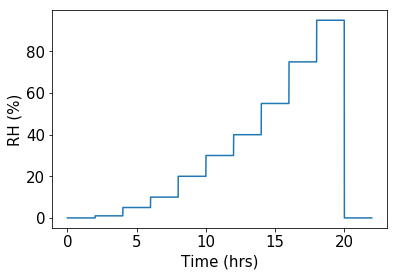

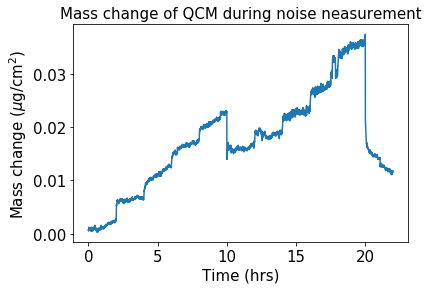

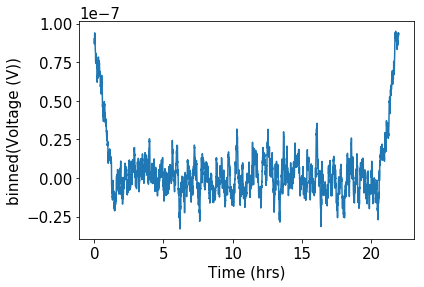

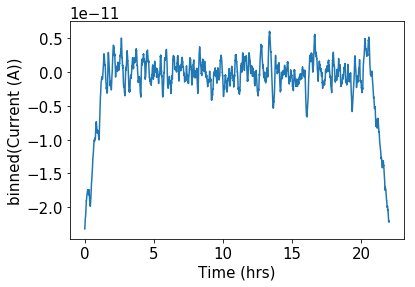

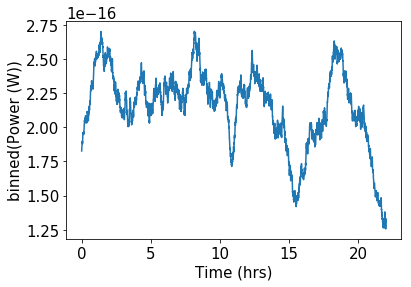

In [17]:
#  MATCH UP NOISE DATA WITH PRESSURE DATA
from scipy import stats

ptime = np.array(pressuredata['elapsed_time_min'] - min(pressuredata['elapsed_time_min']))/60 #pressure times
rh = np.array(pressuredata['pressure_setpoint_Torr']) #pressures (or RH)

#compress each variable to length of pressure data by taking statistics of bins
tmatch = stats.binned_statistic(tlong, tlong, statistic='median', bins=len(ptime))[0] 
vmatch = stats.binned_statistic(tlong, vtfilt, statistic='median', bins=len(ptime))[0]
imatch = stats.binned_statistic(tlong, itfilt, statistic='median', bins=len(ptime))[0]
pmatch = stats.binned_statistic(tlong, ptfilt, statistic='median', bins=len(ptime))[0]

print('min/max noise times = ' + format(min(tlong)) + ' - ' + format(max(tlong)))
print('min/max pressure times = ' + format(min(ptime)) + ' - ' + format(max(ptime)))
print('min/max compressed noise times = ' + format(min(tmatch)) + ' - ' + format(max(tmatch)))
print('# of noise time points = ' + format(len(tlong)))
print('# of pressure time points = ' + format(len(ptime)) + '; # of compressed noise points = ' + format(len(tmatch)))

plt.plot(ptime,rh); plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('RH (%)', fontsize=15);
plt.show() #plot pressure / RH

plt.plot(ptime, pressuredata.iloc[:,6]) #plot QCM response during noise measurement
plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('Mass change ($\mu$g/cm$^2$)', fontsize=15)
plt.title('Mass change of QCM during noise neasurement', fontsize=15); plt.show()

plt.plot(ptime,vmatch); plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('binned(Voltage (V))', fontsize=15); plt.show()
plt.plot(ptime,imatch); plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('binned(Current (A))', fontsize=15); plt.show()
plt.plot(ptime,pmatch); plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('binned(Power (W))', fontsize=15); plt.show()

training time (min) =  2.026 , testing MSE (%) =  141.506
average absolute error (%) =  4.538


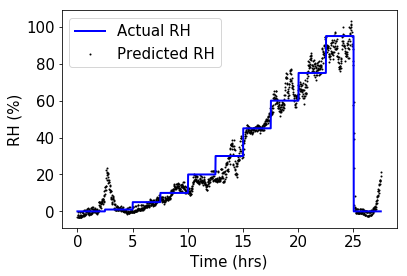

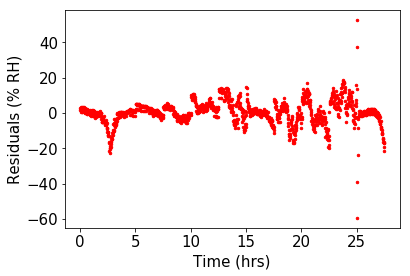

In [36]:
# USE NEURAL NET REGRESSOR TO PREDICT PRESSURE USING NOISE DATA
NNstarttime = timer() #start timer to monitor training time

NNpnts = 1250 #len(vmatch) #number of points to sample for ANN analysis
ptime_short = ptime[::int(len(vmatch)/NNpnts)] #slice to reduce number of data points
vmatch_short = vmatch[::int(len(vmatch)/NNpnts)] 
imatch_short = imatch[::int(len(imatch)/NNpnts)]
pmatch_short = pmatch[::int(len(pmatch)/NNpnts)]
rh_short = rh[::int(len(rh)/NNpnts)]

############## standardize data by subtracting mean and dividing by st. dev. ###########
vmatch_st = np.divide(np.subtract(vmatch_short,np.mean(vmatch_short)),np.std(vmatch_short))
imatch_st = np.divide(np.subtract(imatch_short,np.mean(imatch_short)),np.std(imatch_short))
pmatch_st = np.divide(np.subtract(pmatch_short,np.mean(pmatch_short)),np.std(pmatch_short))
rh_st = np.divide(np.subtract(rh_short,np.mean(rh_short)),np.std(rh_short))

inputlist = (vmatch_st, imatch_st)# insert data to be used as columns for input matrix
targetlist = (rh_st) #insert data to be used as columns for target matrix

#create input matrix and target matrix for feeding into ANN
inputmatrix = np.array(inputlist).T if len(np.shape(inputlist)) > 1 else np.array(inputlist) 
targetmatrix = np.array(targetlist).T if len(np.shape(targetlist)) > 1 else np.array(targetlist)
targetmatrix = targetmatrix.reshape(-1,1)

actual = np.array([]); prediction = np.array([]) #empty arrays for appending ANN results at each k-fold
errors_raw = np.array([]); tar_times = np.array([])

nn = Regressor(layers=[
        Layer('Sigmoid', units=14), # design network with hidden layers
        Layer('Sigmoid', units=5),
        Layer('Sigmoid', units=2),
        Layer('Linear')], #output layer
    learning_rate=0.02, n_iter=1000)
kf = KFold(n_splits=5, shuffle=True) # k-fold validation for ANN testing

for train_index, test_index in kf.split(inputmatrix): #split into k test/train sets and loop oever each one
    inp_train, inp_test = inputmatrix[train_index], inputmatrix[test_index]
    tar_train, tar_test = targetmatrix[train_index], targetmatrix[test_index]

    nn.fit(inp_train, tar_train) #train network
    prediction_raw = nn.predict(inp_test) #make predictions (still standardized)

    prediction0 = np.add(np.multiply(np.std(rh_short),prediction_raw),np.mean(rh_short)) #unstandardize prediction
    actual0 = np.add(np.multiply(np.std(rh_short),tar_test),np.mean(rh_short)) #unstandardize actual target
    prediction = np.append(prediction, prediction0) #build predictions
    actual = np.append(actual, actual0) #build actual targets
    errors_raw = np.append(errors_raw, np.subtract(actual0, prediction0)) #calculate prediction errors
    tar_times = np.append(tar_times, ptime_short[test_index]) #make array of times that correspond to testing points

    #print(nn.get_parameters()) #summarize network parameters

NNendtime = timer(); NNtime = (NNendtime - NNstarttime) / 60 #total training time in minutes
print('training time (min) = ', round(NNtime,3), ', testing MSE (%) = ', round(MSE(actual, prediction),3))
print('average absolute error (%) = ', round(np.mean(np.abs(errors_raw)),3))

plt.plot(ptime_short, rh_short, c='b', linewidth=2, label='Actual RH') #plot pressure / RH
plt.scatter(tar_times, prediction, c='k', s=1, label='Predicted RH') #plot predictions
plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('RH (%)', fontsize=15)
plt.legend(loc='upper left', fontsize=15); plt.show()

plt.scatter(tar_times, errors_raw, c='r', s=6) #plot errors
plt.xlabel('Time (hrs)', fontsize=15); plt.ylabel('Residuals (% RH)', fontsize=15)
plt.show()

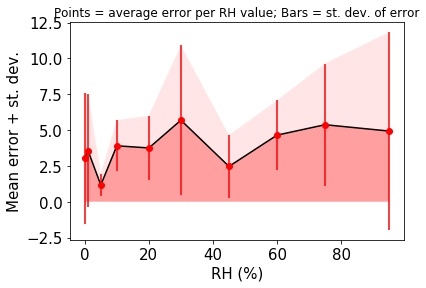

RH values =  [  0.   1.   5.  10.  20.  30.  45.  60.  75.  95.]
avg errors =  [ 3.02  3.57  1.16  3.9   3.75  5.69  2.46  4.65  5.37  4.93]
error st. dev. =  [ 4.59  3.91  0.8   1.79  2.25  5.21  2.18  2.42  4.27  6.9 ]


In [35]:
# Analyze ANN errors
rhvalues = np.unique(actual)
errormean, errorstd = np.array([]), np.array([])
for i in rhvalues: #look through each individual RH value
    error00 = np.array([])
    for j in range(len(errors_raw)): #collect errors at each RH to average them as a function of RH
        if i == actual[j]: error00 = np.append(error00, errors_raw[j]) 
    errormean = np.append(errormean, np.mean(np.abs(error00)))
    errorstd = np.append(errorstd, np.std(np.abs((error00))))

plt.errorbar(rhvalues, errormean, yerr=errorstd, fmt='o', c='r')
plt.plot(rhvalues, errormean, c='k')
plt.fill_between(rhvalues, 0, errormean+errorstd, facecolor='red', alpha=.1, interpolate=True)
plt.fill_between(rhvalues, 0, errormean, facecolor='red', alpha=.3, interpolate=True)


plt.xlabel('RH (%)', fontsize=15); plt.ylabel('Mean error + st. dev.', fontsize=15)
plt.title('Points = average error per RH value; Bars = st. dev. of error')
plt.show()

print('RH values = ', rhvalues)
print('avg errors = ', np.around(errormean, decimals=2))
print('error st. dev. = ', np.around(errorstd, decimals=2))

In [26]:
len(vmatch_st)
#%store errormean

5746

# SAVE NN RESULTS TO CSV FILE

NNfile = "NNresults.csv"
saveNNdata = []; NNheaders = []; savetar = []

#see if input/target lists are multi-dimensional and reshape if necessary
#save test inputs:
if len(np.shape(inputlist)) > 1:
    for i in range(len(inputlist)):
        saveNNdata.append(zip(*inp_test)[i])
        NNheaders.append('test_input' + str(i+1))
else:
    saveNNdata.append(np.reshape(inp_test,len(inp_test)))
    NNheaders.append('test_input')
    
#save test targets and predictions:
if len(np.shape(targetlist)) > 1:
    for i in range(len(targetlist)):
        saveNNdata.append(zip(*tar_test)[i]) 
        NNheaders.append('test_target' + str(i+1))
        saveNNdata.append(zip(*prediction)[i])
        NNheaders.append('prediction' + str(i+1))
else:
    saveNNdata.append(np.reshape(tar_test,len(tar_test)))
    NNheaders.append('test_target')
    saveNNdata.append(np.reshape(prediction, len(tar_test)))
    NNheaders.append('prediction')
                        
saveNNdata = zip(*saveNNdata)
#open CSV file
with open(NNfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerow(NNheaders) #write headers
    for row in saveNNdata:
        writer.writerow(row)

#grid search optimizes network among the choices you give it:
'''
gs = GridSearchCV(nn, param_grid={
    'learning_rate': [0.05, 0.01, 0.005, 0.001],
    'hidden0__units': [4,8,12]
    'hidden0__type': ['Rectifier', 'Sigmoid', 'Tanh']})
gs.fit(X,y)
'''
# or among random parameters:
'''
gs = RandomizedSearchCV(nn, param_distributions={
    'learning_rate': stats.uniform[0.001, 0.1],
    'hidden0__units': stats.radint[3,15],
    'hidden0__type': ['Rectifier', 'Sigmoid', 'Tanh']})
gs.fit(X,y)
'''
#to save trained network:
#pickle.dump(nn, open('nn.pk1', 'wb'))

#to load trained network:
# nn = pickel.load(open('nn.pk1', 'rb'))

